# One Dataset, Two Methods — Why Flexibility Matters in Causal Inference

Imagine you just ran an intervention — a marketing campaign, a policy change, a product launch — and you need to answer a simple question: *did it work?*

You reach for a causal inference tool. Maybe someone on your team says, "Just use CausalImpact." And that's fine — it's a well-known package built by Google, and it does one thing reasonably well: Interrupted Time Series via a Bayesian Structural Time Series (BSTS) model.

But here's the thing. What if the data is *telling you* that ITS isn't the right approach? What if there's a richer structure in your data — multiple control units, not just one noisy time series — and you're leaving information on the table by ignoring it?

That's what we'll explore here. We'll take a single dataset, force it through an ITS lens (using both Google's CausalImpact and CausalPy), and then show that the *correct* methodology for this data is Synthetic Control. CausalPy handles both. CausalImpact doesn't.

Let's see what happens.

## Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import causalpy as cp
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from causalimpact import CausalImpact

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams.update({"figure.constrained_layout.use": True})

seed = sum(map(ord, "causalpy flexibility comparative"))
rng = np.random.default_rng(seed)
print(f"Seed: {seed}")

Seed: 3298


## The Data: A Classic Synthetic Control Setting

We'll use CausalPy's built-in `sc` dataset. This is a textbook scenario: one treated unit (`actual`) and seven control units (`a` through `g`), observed over 100 time periods. The intervention happens at time 73.

In [3]:
df = cp.load_data("sc")
treatment_time = 73

control_units = ["a", "b", "c", "d", "e", "f", "g"]
treated_unit = "actual"

print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Treatment time: {treatment_time}")
df.head()

Shape: (100, 10)
Columns: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'counterfactual', 'causal effect', 'actual']
Treatment time: 73


,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.0,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.0,1.775940


Let's visualize what we're working with. The treated unit lives among a family of control units — some trending up, some trending down, all moving through time together.

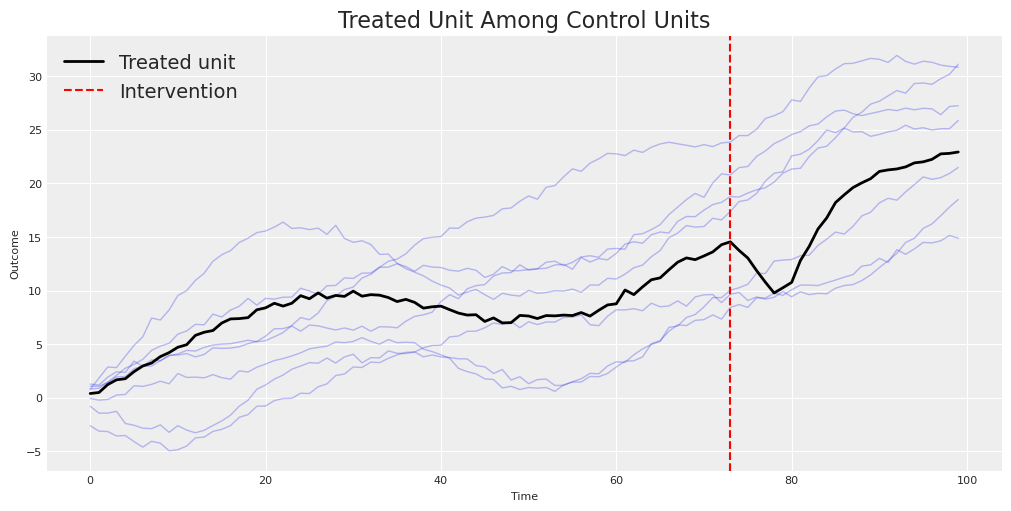

In [4]:
fig, ax = plt.subplots()
for col in control_units:
    ax.plot(df.index, df[col], alpha=0.3, color="C0", linewidth=1)
ax.plot(df.index, df[treated_unit], color="black", linewidth=2, label="Treated unit")
ax.axvline(
    x=treatment_time, color="red", linestyle="--", linewidth=1.5, label="Intervention"
)
ax.set(
    title="Treated Unit Among Control Units",
    xlabel="Time",
    ylabel="Outcome",
)
ax.legend()
plt.show()

Notice the structure: the treated unit doesn't just follow a smooth trend — it tracks a combination of the control units. After the intervention (the red dashed line), something changes. Our job is to estimate *what* changed and by *how much* — the causal effect.

For reference, this dataset comes with ground truth. The known average causal effect is approximately **-1.85 units** — the intervention *decreased* the outcome. Let's see which method gets closest.

## Attempt 1: Google's CausalImpact (BSTS)

Let's start with the tool most people reach for: `pycausalimpact`, the Python port of Google's CausalImpact. This package uses a Bayesian Structural Time Series (BSTS) model to build a counterfactual from pre-intervention data and project it forward.

To keep this a fair comparison, we'll give CausalImpact only the treated unit — no covariates. This puts it on equal footing with CausalPy's ITS: both methods must build a counterfactual from the treated unit's own time series alone.

In [5]:
# Fair comparison: only the treated unit, no covariates
ci_data = df[[treated_unit]].copy()

pre_period = [0, treatment_time - 1]
post_period = [treatment_time, len(df) - 1]

ci = CausalImpact(ci_data, pre_period, post_period)

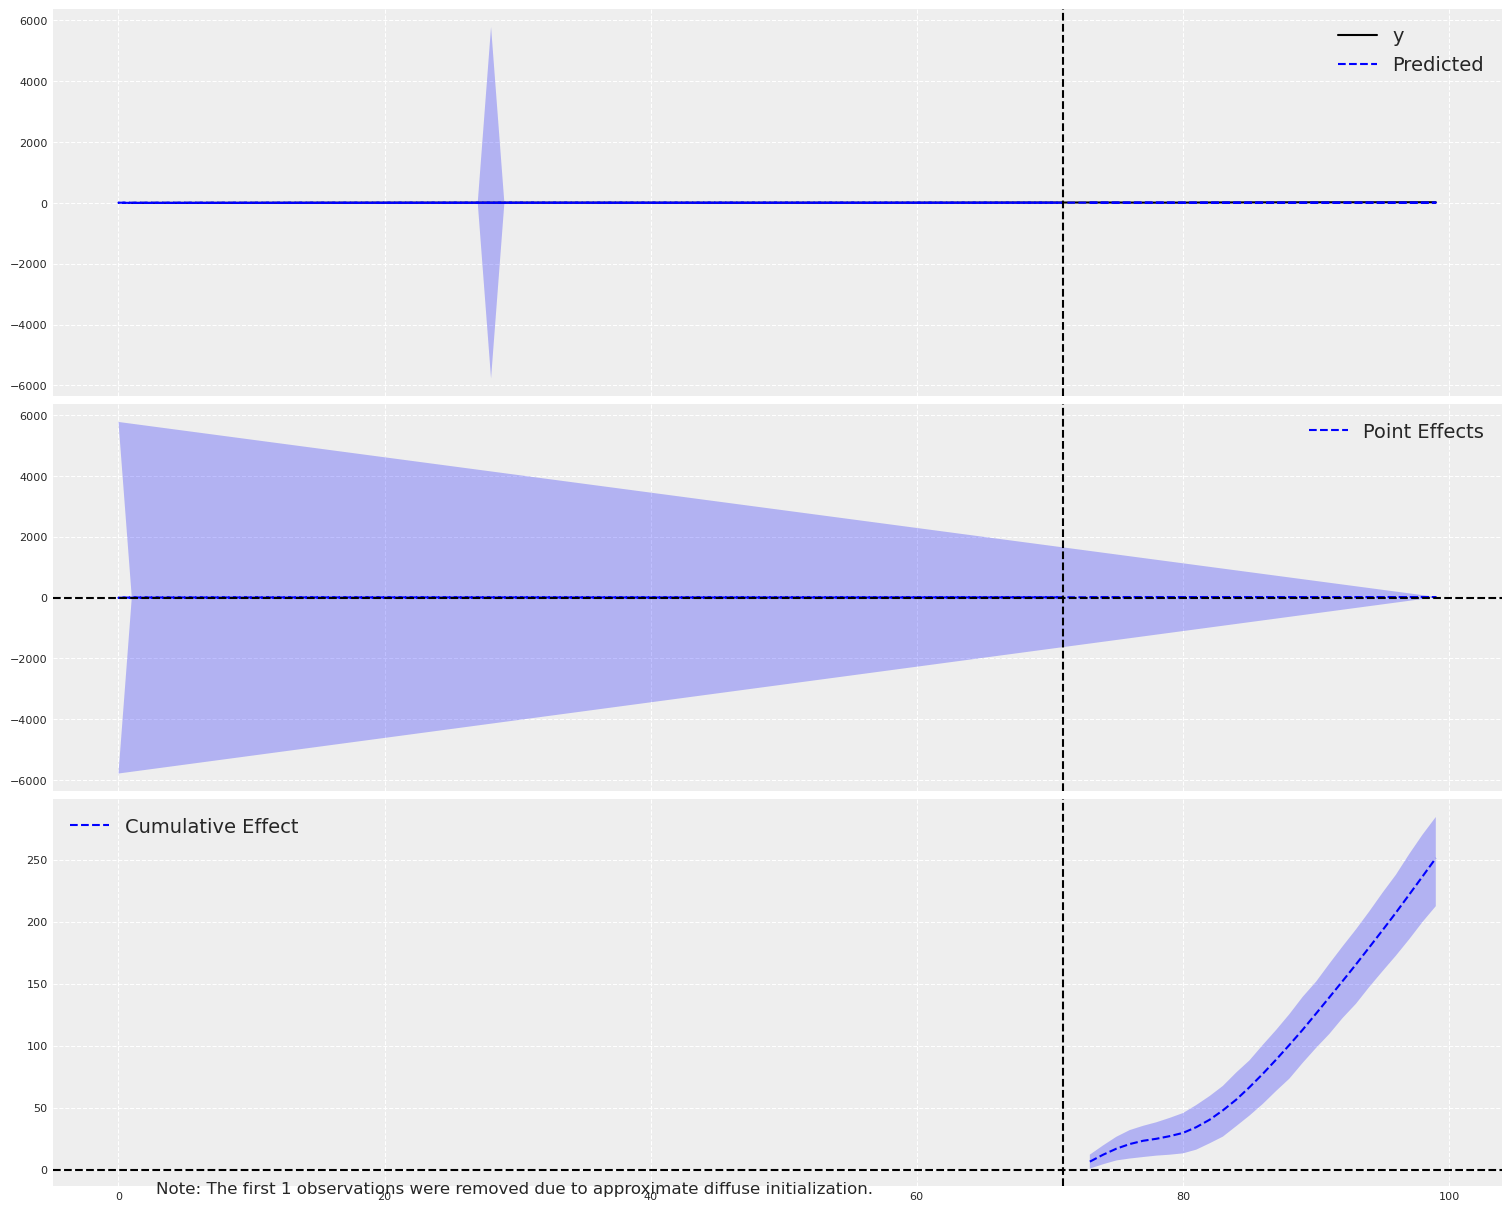

In [6]:
ci.plot()
plt.show()

In [7]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    17.45              471.09
Prediction (s.d.)         8.15 (0.68)        220.01 (18.34)
95% CI                    [6.92, 9.58]       [186.82, 258.71]

Absolute effect (s.d.)    9.3 (0.68)         251.09 (18.34)
95% CI                    [7.87, 10.53]      [212.39, 284.28]

Relative effect (s.d.)    114.13% (8.34%)    114.13% (8.34%)
95% CI                    [96.54%, 129.21%]  [96.54%, 129.21%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


CausalImpact gives us a result. It builds a counterfactual using a BSTS model from the pre-intervention period and projects it forward. The estimated average effect? Around **+9.3**. That's the *wrong sign* — the true effect is negative. CausalImpact, working only from the treated unit's own temporal dynamics, doesn't just miss the magnitude — it gets the *direction* entirely backwards.

Let's keep this in our pocket and see if CausalPy's ITS does any better.

## Attempt 2: CausalPy's ITS (State Space Model)

Now let's try the same ITS approach but using CausalPy's State Space Time Series model. CausalPy's ITS is more transparent — we see the full Bayesian posterior, and we get richer diagnostics.

For ITS, we'll only use the treated unit's time series. No control units — just the treated series and time.

In [8]:
# ITS needs a time-indexed DataFrame with the outcome
df_its = pd.DataFrame(
    {
        "y": df[treated_unit].values,
    },
    index=pd.date_range("2020-01-01", periods=len(df), freq="ME"),
)

its_treatment_time = df_its.index[treatment_time]
print(f"ITS treatment time: {its_treatment_time}")
df_its.head()

ITS treatment time: 2026-02-28 00:00:00


,y
2020-01-31,0.398287
2020-02-29,0.491644
2020-03-31,1.232330
2020-04-30,1.672995
2020-05-31,1.775940


In [ ]:
sampler_kwargs = {
    "nuts_sampler": "nutpie",
    "chains": 4,
    "draws": 500,
    "nuts_sampler_kwargs": {"backend": "jax", "gradient_backend": "jax"},
    "target_accept": 0.96,
}

ssts_model = cp.pymc_models.StateSpaceTimeSeries(
    level_order=3,
    seasonal_length=12,
    sample_kwargs=sampler_kwargs,
    mode="FAST_COMPILE",
)

ssts_result = cp.InterruptedTimeSeries(
    df_its,
    its_treatment_time,
    formula="y ~ 1",
    model=ssts_model,
)

                                 Model Requirements                                 
                                                                                    
  Variable              Shape      Constraints                          Dimensions  
 ────────────────────────────────────────────────────────────────────────────────── 
  initial_level_trend   (3,)                                ('state_level_trend',)  
  sigma_level_trend     (3,)       Positive                 ('shock_level_trend',)  
  params_freq           (11,)                                      ('state_freq',)  
  sigma_freq            ()         Positive                                   None  
  P0                    (15, 15)   Positive semi-definite   ('state', 'state_aux')  
                                                                                    
These parameters should be assigned priors inside a PyMC model block before calling 
                         the build_statespace_graph method.                         

In [ ]:
fig, ax = ssts_result.plot()
plt.show()

CausalPy's ITS with the State Space model produces a result. But look carefully at the counterfactual projection. The model is trying to extrapolate purely from the *treated unit's own temporal structure* — no control units, no cross-sectional information. It's flying blind.

The estimated average effect? Around **-5.2** — it gets the *direction* right (negative), which is already better than CausalImpact, but the magnitude is off by nearly 3x. The true average effect is -1.85. The State Space model, relying solely on the treated unit's temporal dynamics, overshoots considerably. Pure ITS, without any information from control units, misses the mark here.

This is exactly the kind of failure that teaches us something important. Let's ask the right question: **is ITS even the right method for this data?**

## Why ITS is the Wrong Tool Here

Let's pause and think about what we just did. In both CausalImpact and CausalPy's ITS, we modeled the treated unit's time series and projected a counterfactual forward. Both methods relied *only* on the treated unit's own history — CausalImpact with a BSTS framework, and CausalPy's ITS with a state space decomposition (level, trend, and seasonal components). Neither used the control units.

But look at the data again. We have **seven control units** that were *not* affected by the intervention. These aren't just covariates to throw into a regression — they're *donor units* that can be combined to construct a synthetic version of the treated unit.

This is the fundamental insight of the **Synthetic Control** method: instead of modeling time, we model the *relationship between units*. We find a weighted combination of control units that closely matches the treated unit in the pre-intervention period, and then we use that same combination to project what the treated unit *would have done* without the intervention.

:::{important}

## The key difference

- **ITS** asks: "Given the treated unit's own history, what would it have done next?"
- **Synthetic Control** asks: "Given how control units behave, what *combination* of them best approximates the treated unit?"

When you have multiple unaffected control units, Synthetic Control exploits richer information. ITS ignores it.
:::

The problem with ITS here is subtle but important: we're asking a single time series model to extrapolate forward, relying only on the temporal structure of the treated unit itself. Any trend break, seasonality shift, or structural change in the post-period could be misattributed to the intervention. With Synthetic Control, we have a *concurrent control group* — the counterfactual moves with the controls in real time, not from a projection.

## "But what if I add covariates to ITS?"

A natural objection at this point: couldn't we just add the control units as covariates to CausalImpact and fix the problem? After all, CausalImpact *does* accept covariates — it would use the control units as predictors in its BSTS regression component.

This is actually a real technique called **Comparative Interrupted Time Series (CITS)**, and CausalPy supports it too. In CITS, you include control units as predictors in your ITS formula (e.g., `treatment ~ 1 + control`), which helps account for common trends and external shocks that affect both treated and control units simultaneously.

But even CITS has important limitations compared to Synthetic Control:

| Aspect | ITS | CITS | Synthetic Control |
|--------|-----|------|-------------------|
| **Control units** | None | Yes, as predictors | Yes, as donors |
| **Weight constraint** | N/A | None (unconstrained regression) | Sum to 1 (convex combination) |
| **Interpretation** | Counterfactual from time trends | Counterfactual from controls + trends | Weighted combination of controls |
| **Intercept** | Typically yes | Yes | Typically no |

The key differences matter:

- CITS treats controls as **regression predictors** with unconstrained coefficients and an intercept. This means the model can extrapolate *outside* the observed range of the controls — a source of potential bias.
- Synthetic Control constructs a **convex combination** of donors (weights sum to 1, non-negative). This forces the counterfactual to stay within the "envelope" of the controls, which is more principled when the treated unit is genuinely a mixture of the control units.
- CITS is vulnerable to **control unit contamination** — if the intervention indirectly affects the controls, the counterfactual will be biased.

In short, CITS is a real improvement over pure ITS, and sometimes it's exactly the right tool. But it's not Synthetic Control, and the two methods make fundamentally different assumptions.

:::{note}

## Want to go deeper?

CausalPy supports Comparative ITS out of the box. See the [Comparative ITS notebook](its_pymc_comparative.ipynb) for a full worked example using a geo-experimentation scenario, including how to check parallel trends, interpret model coefficients, and diagnose model convergence.
:::

## The Flexibility Problem

Here's where things get interesting from a tooling perspective.

You've just realized that Synthetic Control is the right method for this data. What do you do?

If you're using **CausalImpact**: you're stuck. CausalImpact *only* does BSTS-based ITS. Sure, it can include covariates, but it can't do Synthetic Control. You'd need to find a completely different package, learn a different API, reformat your data, and start over.

If you're using **CausalPy**: you just change the method call. Same data. Same library. Different method. And if you want to try CITS as a middle ground along the way? That's a formula change away too.

Let's see this in action.

## The Right Approach: CausalPy's Synthetic Control

In [ ]:
sc_result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=control_units,
    treated_units=[treated_unit],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={
            "target_accept": 0.95,
            "random_seed": 42,
            "progressbar": True,
            "chains": 4,
            "draws": 300,
        }
    ),
)

In [ ]:
fig, ax = sc_result.plot(plot_predictors=True)
plt.show()

Look at that fit. The synthetic control (the weighted combination of donor units) tracks the treated unit nearly perfectly in the pre-intervention period. After the intervention, we see a clear, clean separation — that's our causal effect estimate.

Let's see the summary statistics.

In [ ]:
sc_result.summary()

In [ ]:
stats = sc_result.effect_summary(treated_unit=treated_unit)
print(stats.text)

## Side-by-Side: Three Estimates, One Truth

Now let's put it all together. We have three estimates of the causal effect:

1. **CausalImpact** (BSTS, no controls)
2. **CausalPy ITS** (State Space, no controls)
3. **CausalPy Synthetic Control** (weighted combination of donors)

And we have the ground truth. Let's compare.

In [ ]:
# Extract the known ground truth from the dataset
true_effect = df["causal effect"].iloc[treatment_time:].values
post_indices = range(treatment_time, len(df))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

# --- Panel 1: CausalImpact (BSTS, no controls) ---
ax = axes[0]
ci_inferences = ci.inferences
post_mask = ci_inferences.index >= treatment_time
ci_effect = ci_inferences["point_effects"][post_mask].values
ci_lower = ci_inferences["point_effects_lower"][post_mask].values
ci_upper = ci_inferences["point_effects_upper"][post_mask].values
n_post = len(true_effect)

ax.fill_between(
    range(n_post), ci_lower, ci_upper, alpha=0.2, color="C0", label="95% CI"
)
ax.plot(range(n_post), ci_effect, color="C0", linewidth=2, label="CausalImpact")
ax.plot(
    range(n_post),
    true_effect,
    color="black",
    linewidth=1.5,
    linestyle="--",
    label="True effect",
)
ax.axhline(y=0, color="grey", linestyle=":", alpha=0.5)
ax.set(
    title="CausalImpact (BSTS, no controls)",
    xlabel="Post-intervention period",
    ylabel="Causal Effect",
)
ax.legend(fontsize=7)

# --- Panel 2: CausalPy ITS (State Space) ---
ax = axes[1]
its_impact = ssts_result.post_impact.isel(treated_units=0)
its_mean = its_impact.mean(("chain", "draw")).values
its_lower = its_impact.quantile(0.025, dim=("chain", "draw")).values
its_upper = its_impact.quantile(0.975, dim=("chain", "draw")).values
n_post = len(true_effect)

ax.fill_between(
    range(n_post), its_lower, its_upper, alpha=0.2, color="C2", label="95% HDI"
)
ax.plot(range(n_post), its_mean, color="C2", linewidth=2, label="CausalPy ITS")
ax.plot(
    range(n_post),
    true_effect,
    color="black",
    linewidth=1.5,
    linestyle="--",
    label="True effect",
)
ax.axhline(y=0, color="grey", linestyle=":", alpha=0.5)
ax.set(title="CausalPy ITS (State Space)", xlabel="Post-intervention period")
ax.legend(fontsize=7)

# --- Panel 3: CausalPy Synthetic Control ---
ax = axes[2]
sc_impact = sc_result.post_impact.sel(treated_units=treated_unit)
sc_mean = sc_impact.mean(("chain", "draw")).values
sc_lower = sc_impact.quantile(0.025, dim=("chain", "draw")).values
sc_upper = sc_impact.quantile(0.975, dim=("chain", "draw")).values

ax.fill_between(
    range(n_post), sc_lower, sc_upper, alpha=0.2, color="C1", label="95% HDI"
)
ax.plot(range(n_post), sc_mean, color="C1", linewidth=2, label="CausalPy SC")
ax.plot(
    range(n_post),
    true_effect,
    color="black",
    linewidth=1.5,
    linestyle="--",
    label="True effect",
)
ax.axhline(y=0, color="grey", linestyle=":", alpha=0.5)
ax.set(title="Synthetic Control (CausalPy)", xlabel="Post-intervention period")
ax.legend(fontsize=7)

fig.suptitle("Effect Estimation: Three Methods, One Ground Truth", fontsize=14)
plt.show()

The story tells itself:

- **CausalImpact** (left panel) gets the sign *completely wrong* — it estimates a large positive effect (~+9.3) when the truth is negative (-1.85). Its BSTS model, lacking control units, extrapolates the pre-intervention trend and misreads the post-intervention data entirely.
- **CausalPy ITS** (center panel) at least gets the direction right (negative), but overshoots the magnitude by ~3x, estimating around -5.2 instead of -1.85. Better, but still far off.
- **CausalPy Synthetic Control** (right panel) tracks the true effect curve closely. The weighted combination of donor units produces a counterfactual that mirrors reality, estimating ~-1.98 against a truth of -1.85.

Let's quantify the differences:

In [ ]:
# Compute mean absolute error for each method
mae_ci = np.mean(np.abs(ci_effect - true_effect))
mae_its = np.mean(np.abs(its_mean - true_effect))
mae_sc = np.mean(np.abs(sc_mean - true_effect))

print(f"{'Method':<35} {'Mean Abs Error':>15} {'Avg Effect':>12} {'True Avg':>10}")
print("-" * 75)
print(
    f"{'CausalImpact (BSTS, no controls)':<35} {mae_ci:>15.3f} {ci_effect.mean():>12.3f} {true_effect.mean():>10.3f}"
)
print(
    f"{'CausalPy ITS (State Space)':<35} {mae_its:>15.3f} {its_mean.mean():>12.3f} {true_effect.mean():>10.3f}"
)
print(
    f"{'CausalPy SC (Synthetic Control)':<35} {mae_sc:>15.3f} {sc_mean.mean():>12.3f} {true_effect.mean():>10.3f}"
)

The numbers tell the story clearly:

- **CausalImpact** gets the wrong sign and has the highest MAE by far. Without covariates, its BSTS model simply can't build a meaningful counterfactual for this data.
- **CausalPy ITS** does better — it gets the direction right — but overshoots the magnitude significantly. Pure time series extrapolation without controls isn't enough.
- **CausalPy SC** dominates, with a MAE roughly **14x lower** than CausalPy ITS and **46x lower** than CausalImpact. The right method, applied to the right data structure, makes all the difference.

But here's the real kicker: with CausalPy, we ran *both* ITS and SC in the same notebook, with the same library, in a few lines of code. We discovered that ITS wasn't working, pivoted to Synthetic Control, and got an accurate estimate — all within the same framework. With CausalImpact, you only get ITS. When that's wrong — as we just showed — you're on your own.

## What We've Learned

Let's crystallize the key takeaways:

1. **Method selection matters more than tool sophistication.** CausalImpact is a well-engineered tool, but it only offers one method. When that method doesn't match your data structure, no amount of tuning will fix the fundamental mismatch.

2. **ITS is not wrong — it's limited.** When you only have a single time series and no control units, ITS is exactly what you need. But when you have donor units available, Synthetic Control exploits strictly more information.

3. **CausalPy gives you flexibility.** With CausalPy, switching from ITS to Synthetic Control is a matter of changing one function call. Same library, same workflow, same Bayesian infrastructure. You're not locked into a single methodology.

4. **The right counterfactual comes from the right model.** A counterfactual built from concurrent controls (Synthetic Control) will generally outperform one built from temporal extrapolation alone (ITS) when the data supports it.

5. **Don't let your tool choose your method.** The method should follow from the data and the research question — not from which package you happen to have installed.

:::{tip}
## The bottom line

CausalPy doesn't just give you Synthetic Control and ITS. It also supports Difference-in-Differences, Regression Discontinuity, and more — all within a unified Bayesian framework. You select the method based on your data and your question, not based on what your tool can do.
:::

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p causalpy,pymc,arviz